In [1]:
# Modulos básicos
import numpy as np
#from pylab import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange, tqdm_notebook
# Modulos para astrofisica/solar
import astropy
from sunpy.net import vso
import astropy.units as u
from sunpy.map import Map
from astropy.io import fits # to fix headers
# Custom-made methods and classes for fixing headers
from lib.CompatMaps import sinehpc_wcs_frame_mapping

# Obtener los datos
Se usa el cliente VSO de SunPy para obtener los datos automáticamente, solo se tienen que cambiar las fechas correspondientes. Fechas de interés para el proyecto son:
* 2011/02/12 a 2011/02/17
* 2012/01/23 a 2012/01/28
* 2013/03/04 a 2013/03/09
* 2014/09/23 a 2013/09/28
* 2015/09/03 a 2015/09/08

In [2]:
# definir instrumento
instrument = 'hmi'
# definir rango de longitud de onda (min,max)
wavelength = 400*u.nm , 700*u.nm
# Definir lapso de tiempo - formato yyyy/mm/dd, yyyy/mm/dd
tstart, tend = '2011/02/12 00:00', '2011/02/17 23:59'
# Query data - Buscar datos en esas fechas
data_client = vso.VSOClient()
data_query = data_client.query(vso.attrs.Time(tstart,tend), \
                               vso.attrs.Instrument(instrument), vso.attrs.Wave(wavelength[0], wavelength[1]))
print("Found ",len(data_query)," records.")

Found  2343  records.


In [3]:
print("Time range: ", data_query.time_range())
print("Size in KB: ", data_query.total_size())

Time range:  (datetime.datetime(2011, 2, 12, 0, 0), datetime.datetime(2011, 2, 17, 23, 58, 58))
Size in KB:  63727.0


In [7]:
# Guardar resultados (Solo hace falta hacerlo una vez)
data_dir = '/home/ivan/projects/Physics/solar/solar-physics-ex/rotation/data/{file}.fits'
results = data_client.get(data_query, path=data_dir).wait()

# Arreglando headers de archivos FITS descargados
Desafortunadamente para ver los resultados hay muchas imágenes que no tienen los headers correctos, entonces es necesario hacer algo como lo que se muestra en este enlace para corregir estos problemas: http://docs.sunpy.org/en/latest/generated/gallery/gallery/hmi_synoptic_maps.html and specially the updated example in: https://gist.github.com/Cadair/cbc73dc7888b9bae5d06708270aedd68

In [24]:
basepath = !pwd
fits_files = !ls data/
np.shape(fits_files)

(43,)

In [25]:
# Fixing headers programatically
#for i in tqdm_notebook(fits_files):
fitsfile = fits.open(basepath[0]+'/data/'+fits_files[4])
fitsfile.verify('fix')
header = (fitsfile[0].header)
if header['CUNIT2'] == 'sin(latitude)' and header['CTYPE1'] == 'CRLN-CEA' and header['CTYPE2'] == 'CRLT-CEA':
    #tqdm.write("Wrong header information found in %s. Changing..." % i)
    header['CUNIT2'] = 'deg'
    header['CTYPE1'] == 'CSLN-CEA'
    header['CTYPE2'] == 'CSLT-CEA'
try:
    if header['HGLN_OBS'] == 'nan':
        del header['HGLN_OBS']
except KeyError:
    #tdqm.write("Warning: Key not found, letting it pass.")
    print("Warning: Key not found, letting it pass.")
    pass
if header.get('CD1_2') == None:
    header['CD1_2'] = 0
if header.get('CD2_1') == None:
    header['CD2_1'] = 0

In [6]:
astropy.wcs.utils.WCS_FRAME_MAPPINGS.append([sinehpc_wcs_frame_mapping]) # Adding the map to the WCS astropy utils module

# Graficar visualizar resultados de la búsqueda

In [26]:
# Making the map 
data = fitsfile[0].data
m = Map((data, header))
# Set the colorbar properties.
m.plot_settings['cmap'] = 'hmimag'
m.plot_settings['norm'] = plt.Normalize(-1500, 1500)

In [27]:
fig = plt.figure(figsize=(12, 5))
axes = plt.subplot(projection=m)

# Plot the image
im = m.plot()

# Set up the Sine Latitude Grid
x = axes.coords[0]
y = axes.coords[1]

x.set_coord_type('longitude', coord_wrap=360.)

x.set_major_formatter('dd')
y.set_major_formatter('d.d')

x.set_axislabel("Carrington Longitude [deg]")
y.set_axislabel("Sine Latitude")


x.set_ticks(color='black', exclude_overlapping=True)
y.set_ticks(color='black', exclude_overlapping=True)

# Hide the grid
axes.coords.grid(alpha=0)

# Create a colorbar
cb = plt.colorbar(im, fraction=0.019, pad=0.1)
cb.set_label("LOS Magnetic Field [Gauss]")

# Now create the overlay in the actual HGC coordinate frame

overlay = axes.get_coords_overlay('heliographic_carrington')

lon = overlay[0]
lat = overlay[1]

lon.set_ticklabel_visible(False)

lat.set_major_formatter('dd')

lat.set_axislabel('Solar Latitude [deg]')

lat.set_ticks_position('tr')
lat.set_ticks(spacing=10*u.deg, exclude_overlapping=True)

# Another horrible hack to make the ticks draw on the RHS
axes.set_xlim((0, 3585))

plt.title("HMI Daily Synoptic Frame for Carrington Rotation"
          " {}-{}".format(header['CAR_ROT'], header['CAR_ROT']+1))

plt.show()

TypeError: Invalid dimensions for image data

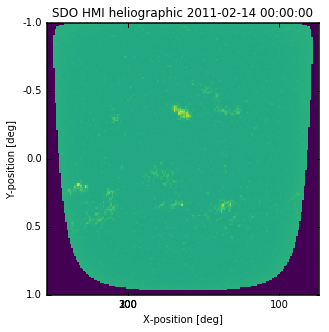

In [28]:
plt.imshow(data[1])
plt.show()